In [63]:
import pandas as pd
import pandas as pd
import numpy as np
import torch
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from blocksnet.relations import generate_adjacency_graph
from blocksnet.enums import LandUse
from torch_geometric.nn import GraphSAGE
import torch.nn as nn

blocks = pd.read_pickle('blocks.pickle')

In [64]:
blocks['site_length'] = blocks.length
blocks['x'] = blocks.centroid.x
blocks['y'] = blocks.centroid.y
# blocks['footprint_area'] /= blocks['site_area']
# blocks['build_floor_area'] /= blocks['site_area']
# blocks['living_area'] /= blocks['site_area']
blocks = blocks[blocks.area>0].copy()

In [65]:
# Generate full graph
graph = generate_adjacency_graph(blocks, 10)
graph = nx.convert_node_labels_to_integers(graph)
edges_list = list(graph.edges)
edge_index = np.array(edges_list).T

2025-07-15 16:26:45.382 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:9 - Generating nodes
2025-07-15 16:26:45.387 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:14 - Generating edges
2025-07-15 16:26:48.752 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:37 - Adjacency graph successfully generated: 9312 nodes, 30110 edges


In [66]:
# Define columns
TARGET_COLUMNS = ['footprint_area', 'build_floor_area', 'living_area']
FEATURE_COLUMNS = ['site_length', 'site_area', 'x', 'y'] + [lu.value for lu in LandUse]

In [67]:
# Feature engineering


def feature_engineering(blocks: pd.DataFrame) -> pd.DataFrame:
    blocks_df = blocks.copy()
    blocks_df['distance_to_center'] = np.sqrt(blocks_df['x']**2 + blocks_df['y']**2)

    blocks_df['x_normalized'] = blocks_df['x'] / (blocks_df['x'].std() + 1e-8)
    blocks_df['y_normalized'] = blocks_df['y'] / (blocks_df['y'].std() + 1e-8)
    blocks_df['lu_diversity'] = blocks_df[[lu.value for lu in LandUse]].sum(axis=1)
    blocks_df['is_mixed_use'] = (blocks_df[[lu.value for lu in LandUse]].sum(axis=1) > 1).astype(int)
    blocks_df['site_length_log'] = np.log1p(blocks_df['site_length'])
    blocks_df['site_length_squared'] = blocks_df['site_length'] ** 2
    # blocks_df['build_density'] = blocks_df['site_area'] / (blocks_df['site_area'] + 1e-8)
    # blocks_df['living_ratio'] = blocks_df['living_area'] / (blocks_df['site_area'] + 1e-8)
    # blocks_df['footprint_ratio'] = blocks_df['site_area'] / (blocks_df['site_length'] + 1e-8)
    feature_columns = FEATURE_COLUMNS + [
        'distance_to_center', 'x_normalized', 'y_normalized',
        'lu_diversity', 'is_mixed_use', 'site_length_log', 'site_length_squared',
        #'build_density', 'living_ratio', 'footprint_ratio'
    ]
    return blocks_df[feature_columns + TARGET_COLUMNS]

# Apply feature engineering
blocks = feature_engineering(blocks)

In [68]:
blocks

,site_length,site_area,x,y,residential,business,recreation,industrial,transport,special,...,distance_to_center,x_normalized,y_normalized,lu_diversity,is_mixed_use,site_length_log,site_length_squared,footprint_area,build_floor_area,living_area
0,6.386234,0.032316,349423.819885,6.631181e+06,0.000000,0.0,0.000000,0.000000,1.000000,0.0,...,6.640381e+06,26.962622,426.265176,1.000000,0,1.999618,4.078398e+01,0.000000,0.000000,0.000000
1,2193.855496,137101.088247,351891.243058,6.633885e+06,0.099000,0.0,0.079912,0.000000,0.401072,0.0,...,6.643211e+06,27.153016,426.438962,0.997003,0,7.693871,4.813002e+06,69.018103,69.018103,0.000000
2,1508.777966,95239.084434,346848.697779,6.618497e+06,1.000000,0.0,0.000000,0.000000,0.000000,0.0,...,6.627579e+06,26.763917,425.449799,1.000000,1,7.319718,2.276411e+06,5853.863274,6106.759644,4197.188633
3,2248.336940,125919.330984,347112.049094,6.618339e+06,0.729125,0.0,0.270875,0.000000,0.000000,0.0,...,6.627435e+06,26.784238,425.439635,1.000000,1,7.718391,5.055019e+06,4214.828165,4375.483259,3033.795607
4,2001.684796,169860.164494,355059.236032,6.618796e+06,0.454375,0.0,0.000000,0.000000,0.144935,0.0,...,6.628313e+06,27.397468,425.469035,0.999293,0,7.602244,4.006742e+06,13392.846325,31242.324144,20860.965881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9363,778.111801,16802.384600,346574.899872,6.647655e+06,0.937805,0.0,0.000000,0.000000,0.062195,0.0,...,6.656683e+06,26.742790,427.324139,1.000000,1,6.658155,6.054580e+05,4360.962708,21549.418762,9911.577637
9364,1001.558725,47637.956433,346205.483186,6.647675e+06,0.125516,0.0,0.266734,0.000000,0.607750,0.0,...,6.656684e+06,26.714285,427.325431,1.000000,1,6.910311,1.003120e+06,14963.573074,73149.192154,0.000000
9365,1275.728432,64487.699525,343969.796461,6.648982e+06,0.000000,0.0,0.763388,0.000000,0.231754,0.0,...,6.657873e+06,26.541772,427.409411,0.995142,0,7.152056,1.627483e+06,25.673922,25.673922,0.000000
9366,942.417410,42988.399080,346204.925815,6.649575e+06,0.404385,0.0,0.000000,0.471607,0.124008,0.0,...,6.658581e+06,26.714242,427.447543,1.000000,1,6.849509,8.881506e+05,12973.889317,52737.331333,0.000000


In [69]:
train_mask = torch.zeros(len(blocks), dtype=torch.bool)
test_mask = torch.zeros(len(blocks), dtype=torch.bool)
train_indices, test_indices = train_test_split(range(len(blocks)), train_size=0.8)
train_mask[train_indices] = True
test_mask[test_indices] = True

In [70]:
# Define model
class MultiScaleGNN(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.output_size = output_size
        self.graphsage = GraphSAGE(
            in_channels=input_size,
            hidden_channels=hidden_dim,
            num_layers=num_layers,
            out_channels=hidden_dim,
            dropout=dropout,
            act='relu',
            norm=nn.LayerNorm(hidden_dim),
            jk='cat'
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, output_size)
        )
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, *args, **kwargs):
        features = self.graphsage(x, edge_index)
        output = self.output_layer(features)
        return output

In [71]:
# Initialize strategy
from blocksnet.machine_learning.strategy.torch.graph import TorchGraphImputationStrategy

strategy = TorchGraphImputationStrategy(
    model_cls=MultiScaleGNN,
    scalers={'x': StandardScaler(), 'y': StandardScaler()}
)

In [72]:
x = blocks[FEATURE_COLUMNS].values
y = blocks[TARGET_COLUMNS].values

In [83]:
train_losses, test_losses = strategy.train(
    x=x,
    y=y,
    edge_index=edge_index,
    train_mask=train_mask,
    test_mask=test_mask,
    epochs=5000,
    optimizer_params={"lr": 1e-4, "weight_decay": 1e-3},
    # data_loader_params={"batch_size": 1, "shuffle": False}
)

/home/vasilstar/masterplanning/blocksnet/machine_learning/strategy/torch/graph/imputation_strategy.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result['train_mask'] = torch.tensor(train_mask, dtype=torch.bool, device=self.device)
/home/vasilstar/masterplanning/blocksnet/machine_learning/strategy/torch/graph/imputation_strategy.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result['test_mask'] = torch.tensor(test_mask, dtype=torch.bool, device=self.device)
Train loss: 0.15394 | Test loss: 0.36286: 100%|██████████| 5000/5000 [01:08<00:00, 73.31it/s]


In [84]:
import numpy as np

def generate_missing_mask(shape: tuple, missing_rate: float = 0.4) -> np.ndarray:
    mask = np.ones(shape, dtype=bool)
    n_rows, n_cols = shape
    for col in range(n_cols):
        missing_indices = np.random.choice(n_rows, int(n_rows * missing_rate), replace=False)
        mask[missing_indices, col] = False
    return mask

In [85]:
import numpy as np
from sklearn.metrics import r2_score

# Создание маски отсутствующих значений
imputation_mask = generate_missing_mask(
    shape=(len(blocks), len(TARGET_COLUMNS)), missing_rate=0.4
)

# Предсказания по всей выборке
predictions = strategy.predict(
    x=blocks[FEATURE_COLUMNS].values,
    y=blocks[TARGET_COLUMNS].values,
    edge_index=edge_index,
    imputation_mask=torch.tensor(imputation_mask, dtype=torch.bool),
)

# Истинные значения
y_true = blocks[TARGET_COLUMNS].values

# R² по каждому таргету
for i, col in enumerate(TARGET_COLUMNS):
    mask = ~imputation_mask[:, i]  # где значение было замаскировано (т.е. модель предсказывала)
    r2 = r2_score(y_true[mask, i], predictions[mask, i])
    print(f"{col}: R² = {r2:.4f}")

# R² по всем предсказанным точкам (flatten)
total_mask = ~imputation_mask  # бинарная маска для всех таргетов
y_true_flat = y_true[total_mask]
predictions_flat = predictions[total_mask]
r2_total = r2_score(y_true_flat, predictions_flat)
print(f"Total R²: {r2_total:.4f}")

/home/vasilstar/masterplanning/blocksnet/machine_learning/strategy/torch/graph/imputation_strategy.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result['imputation_mask'] = torch.tensor(imputation_mask, dtype=torch.bool, device=self.device)


footprint_area: R² = 0.7991
build_floor_area: R² = 0.8700
living_area: R² = 0.8461
Total R²: 0.8672



=== Plotting Loss Curves ===


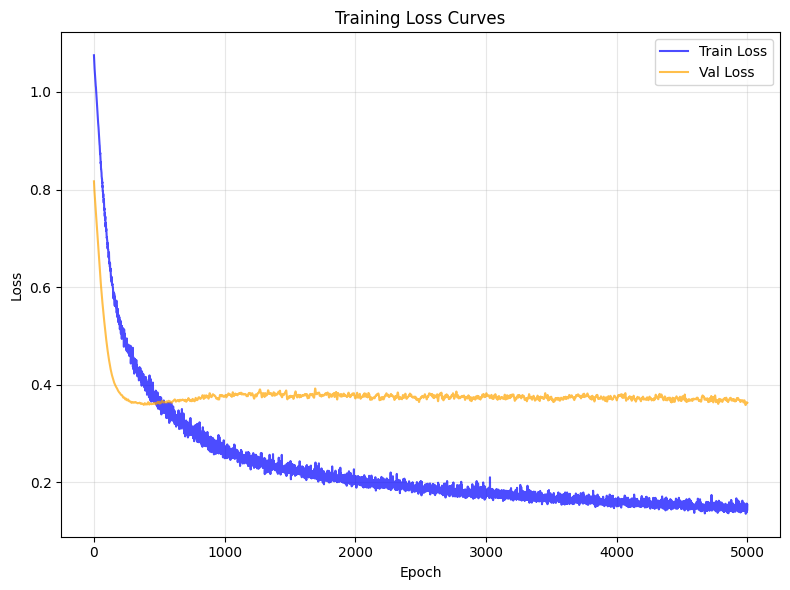

In [88]:
import matplotlib.pyplot as plt
from typing import List

# Функция для отображения только потерь
def plot_losses(train_losses: List[float], test_losses: List[float], title: str):
    """
    Plot training and test losses over epochs.
    """
    print("\n=== Plotting Loss Curves ===")
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss', alpha=0.7, color='blue')
    plt.plot(test_losses, label='Val Loss', alpha=0.7, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Вызов функции (передайте соответствующие списки)
plot_losses(train_losses, test_losses, title='Training Loss Curves')


In [87]:
# Save model
strategy.save('./graph_imputation_model')

# Load model
strategy = TorchGraphImputationStrategy(model_cls=MultiScaleGNN)
strategy.load('./graph_imputation_model')